In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.utils import image_dataset_from_directory

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

2.16.2
Num GPUs Available:  1


Data Preprocessing 

In [ ]:
training_data = "data/Training"
testing_data = "data/Testing"

class_names = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

def normalize_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label


In [2]:
training_data = "data/Training"
testing_data = "data/Testing"

class_names = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

def normalize_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_generator = image_dataset_from_directory(
    training_data,
    subset='training',
    seed=50,
    image_size=(256, 256),
    batch_size=64,
    validation_split=0.1,
).map(normalize_image)

validation_generator = image_dataset_from_directory(
    training_data,
    subset='validation',
    seed=50,
    image_size=(256, 256),
    batch_size=64,
    validation_split=0.3,
).map(normalize_image)

test_generator = image_dataset_from_directory(
    testing_data,
    image_size=(256, 256),
    batch_size=64,
    seed=50
).map(normalize_image)


Found 5712 files belonging to 4 classes.
Using 5141 files for training.
Found 5712 files belonging to 4 classes.
Using 1713 files for validation.
Found 1311 files belonging to 4 classes.


Show graph

In [16]:

# Code for plotting
def show(images, labels):
    plt.figure(figsize=(10, 10))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.xlabel(class_names[labels[i]])
    plt.show()

# show(train_generator, class_names)

Model

In [30]:
model = models.Sequential()

model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(4, activation='softmax'))
print(model.summary())


model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy'])

batch_size = 64
epochs = 10

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,256,100 (16.24 MB)

 Trainable params: 4,256,100 (16.24 MB)

 Non-trainable params: 0 (0.00 B)

None


Fit

In [31]:
model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
)


Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.5164 - loss: 1.1006 - val_accuracy: 0.8190 - val_loss: 0.4873
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 38s 471ms/step - accuracy: 0.8081 - loss: 0.4964 - val_accuracy: 0.8926 - val_loss: 0.3127
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1956s 24s/step - accuracy: 0.8724 - loss: 0.3628 - val_accuracy: 0.9229 - val_loss: 0.2366
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 39s 483ms/step - accuracy: 0.9001 - loss: 0.2645 - val_accuracy: 0.8943 - val_loss: 0.3148
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 36s 441ms/step - accuracy: 0.9066 - loss: 0.2459 - val_accuracy: 0.9416 - val_loss: 0.1789
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 36s 447ms/step - accuracy: 0.9367 - loss: 0.1707 - val_accuracy: 0.9609 - val_loss: 0.1330
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 38s 468ms/step - accuracy: 0.9460 - loss: 0.1378 - val_accuracy: 0.9726 - val_loss: 0.1008
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 39s 482ms/step - accuracy: 0.9715 - loss: 0.0877 - val_accu

Evaulation

In [32]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy:.2f}')
print(f'Test loss: {test_loss:.2f}')

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9607 - loss: 0.1548
Test accuracy: 0.96
Test loss: 0.16


Save models

In [35]:
model.save("model.keras")
# model.save("Neual_network_model")

Confusion Matrix

In [33]:
class estimator:
  _estimator_type = ''
  classes_=[]
  def __init__(self, model, classes):
    self.model = model
    self._estimator_type = 'classifier'
    self.classes_ = classes
  def predict(self, X):
    y_prob= self.model.predict(X)
    y_pred = y_prob.argmax(axis=1)
    return y_pred

classifier = estimator(model, class_names)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


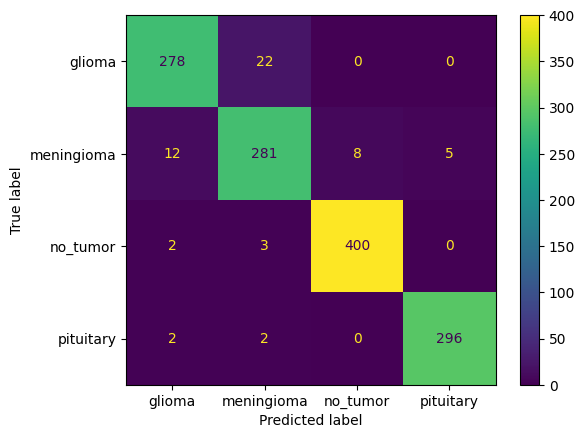

              precision    recall  f1-score   support

      glioma       0.95      0.93      0.94       300
  meningioma       0.91      0.92      0.92       306
    no_tumor       0.98      0.99      0.98       405
   pituitary       0.98      0.99      0.99       300

    accuracy                           0.96      1311
   macro avg       0.96      0.95      0.96      1311
weighted avg       0.96      0.96      0.96      1311



In [34]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.show()

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_true = []
y_pred = []
for x, y in test_generator:
    y_true.extend(y.numpy())
    y_pred.extend(classifier.predict(x))
y_true = np.array(y_true)
y_pred = np.array(y_pred)

plot_confusion_matrix(y_true, y_pred, class_names)
print(classification_report(y_true, y_pred, target_names=class_names))